# Preprocess

Import the necessary libraries.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pysiology
from tqdm.notebook import tqdm

Thank you for using Pysiology. If you use it in your work, please cite:
Gabrieli G., Azhari A., Esposito G. (2020) PySiology: A Python Package for Physiological Feature Extraction. In: Esposito A., Faundez-Zanuy M., Morabito F., Pasero E. (eds) Neural Approaches to Dynamics of Signal Exchanges. Smart Innovation, Systems and Technologies, vol 151. Springer, Singapore. https://doi.org/10.1007/978-981-13-8950-4_35


Load the sharpwave data from files, and ignore lines with missing values.

In [2]:
# data_dir = os.path.join(os.path.dirname(__file__), 'data')
data_dir = 'data'
data_names = [f'20151026_{i}' for i in range(1, 1001)]
num_seqs = len(data_names)

data: list[npt.NDArray[np.float64]] = []

for i in tqdm(range(num_seqs), desc='Loading data'):
    # Load data from file
    data_path = os.path.join(data_dir, data_names[i])
    # Ignore the row if data is missing
    data.append(np.genfromtxt(data_path, invalid_raise=False))

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_11744\886268642.py:12: ConversionWarning: Some errors were detected !
    Line #44998 (got 3 columns instead of 4)
    Line #44999 (got 3 columns instead of 4)
    Line #45000 (got 3 columns instead of 4)
  data.append(np.genfromtxt(data_path, invalid_raise=False))


Extract features from the data after applying a bandpass filter, and combining the four channels.

  0%|          | 0/1000 [00:00<?, ?it/s]

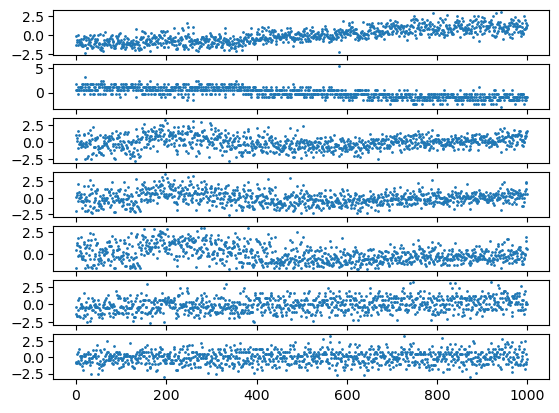

In [3]:
features = np.zeros((len(data), 7), dtype=np.float64)

for i in tqdm(range(num_seqs)):
    # Merging channels into one
    avg = np.sum(data[i], axis=1) / data[i].shape[1]
    # Calculate features after filtering
    result = pysiology.electrocardiography.analyzeECG(avg, 3000, highpass=1, lowpass=30,
                                                      pnn50pnn20=False,
                                                      freqAnalysis=False,
                                                      freqAnalysisFiltered=False)
    features[i, 0] = result['ibi']
    features[i, 1] = result['bpm']
    features[i, 2] = result['sdnn']
    features[i, 3] = result['sdsd']
    features[i, 4] = result['rmssd']
    features[i, 5] = result['pnn50']
    features[i, 6] = result['pnn20']

# Normalize data
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Plot data
fig, axs = plt.subplots(7, 1, sharex=True)
for i, ax in enumerate(axs.flat):
    ax.scatter(range(features.shape[0]), features[:, i], s=1)

plt.show()

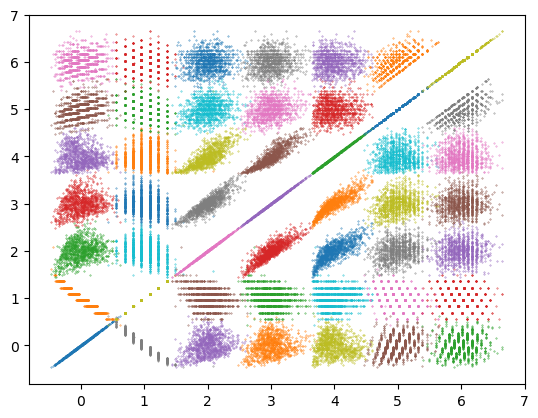

In [4]:
for i, j in np.ndindex((7, 7)):
    plt.scatter(features[:, i]/5+i, features[:, j]/5+j, s=0.1)

In [5]:
# np.savetxt('features.txt', features)